# Mô hình hồi quy tuyến tính Bayes với pyMC3

Bs. Lê Ngọc Khả Nhi,
Ngày 06/9/218;

## Giới thiệu

pyMC3 là một thư viện lập trình xác suất để làm thống kê Bayes cho ngôn ngữ Python. Không chỉ có khả năng mạnh mẽ cho phép người dùng tự thiết kế nhiều mô hình Bayes tùy ý thích, pyMC3 còn hỗ trợ phương pháp hồi quy tuyến tính đơn giản bằng hàm GLM. Cách làm này chịu ảnh hưởng rõ nét từ phong cách của ngôn ngữ R. 

Trong bài thực hành hôm nay, Nhi sẽ minh họa mô hình GLM trong pyMC3 bằng một phân tích hồi quy logistic. Ngoài ra, các bạn cũng sẽ biết thêm một số chiêu thức khác như so sánh nhiều mô hình Bayes và Bayesian model averaging (BMA).

In [1]:
# Không chạy đoạn code này nếu máy tính bạn không sử dụng GPU. 

import os
os.environ["THEANO_FLAGS"]="mode=FAST_RUN,device=cuda0,floatX=float64"

In [206]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

Đầu tiên, bạn tải dữ liệu từ thư mục hiện hành, đây là phiên bản rút gọn của nghiên cứu về "Sốc nhiễm trùng" lấy từ giáo trình Machine learning cookbook cho SPSS modeler. Ngoài Leucocytes là biến số nguyên, Nhi đã chuẩn hóa biến Creatinine Clearance; recode biến Creatinine thành một biến nhị phân : 1= Cao, 0 = Bình thường/thấp; và recode biến Outcome thành biến số nhị phân Death (1= bệnh nhân tử vong, 0= bệnh nhân sống sót). Như vậy chúng ta sẽ có một dữ liệu bao quát đủ các loại biến.

Lưu ý: pyMC3 chạy trên theano, do đó nó chỉ tiếp nhận dữ liệu đầu vào là những tensor (array) số nguyên (int64, int32) hoặc liên tục (float64, float32). Nếu dữ liệu có biến categorical, bạn phải recode lại thành dummy variables.

In [4]:
data = pd.read_csv('sepsislogistic.csv',header=0,sep=";")

data.head(10)

,Death,Urea,Leucocytes,HighCrea,Clearance,Outcome
0,0,3.4,5,0,-0.736,Survive
1,0,2.0,6,0,-0.760,Survive
2,0,5.6,4,0,-0.855,Survive
3,0,6.0,7,0,-0.712,Survive
4,0,6.1,6,1,-0.951,Survive
5,0,5.4,8,0,-1.237,Survive
6,0,5.3,5,0,-0.951,Survive
7,0,6.3,6,0,-1.237,Survive
8,0,6.0,7,1,-0.760,Survive
9,0,4.0,6,0,-1.070,Survive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
Death         200 non-null int64
Urea          200 non-null float64
Leucocytes    200 non-null int64
HighCrea      200 non-null int64
Clearance     200 non-null float64
Outcome       200 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 9.5+ KB


Như thường lệ, Nhi thăm dò dữ liệu một cách trực quan bằng package plotnine - đây là một phiên bản ggplot2 cho Python, cú pháp của nó giống y như ggplot2 trong R.

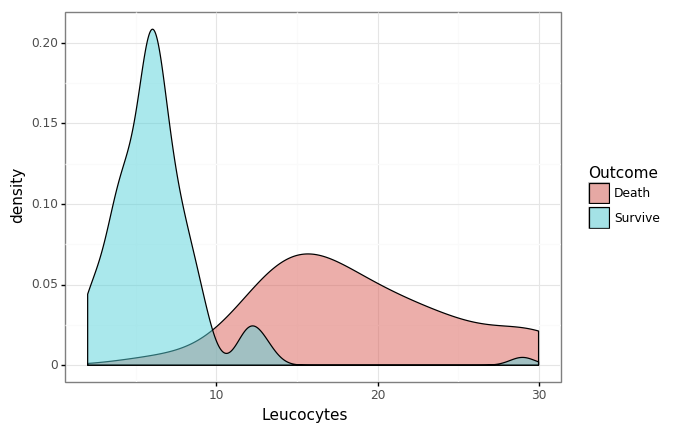

<ggplot: (-9223371901588957482)>

In [220]:
from plotnine import *
%matplotlib inline

(ggplot(data)
 + geom_density(aes('Leucocytes',fill='Outcome'),alpha=0.5)
 + theme_bw())

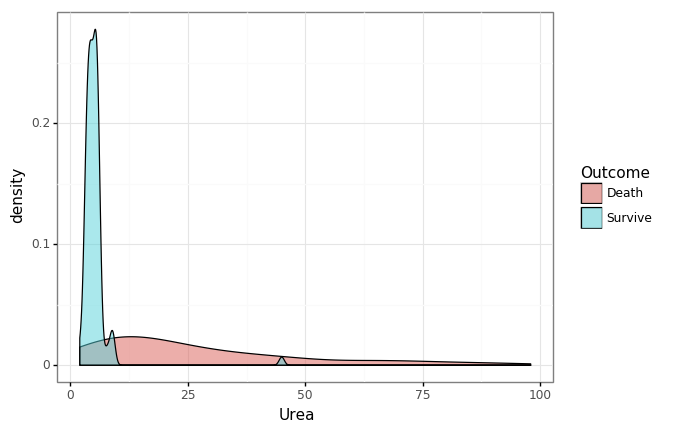

<ggplot: (-9223371901586676508)>

In [230]:
(ggplot(data)
 + geom_density(aes('Urea',fill='Outcome'),alpha=0.5)
 + theme_bw())

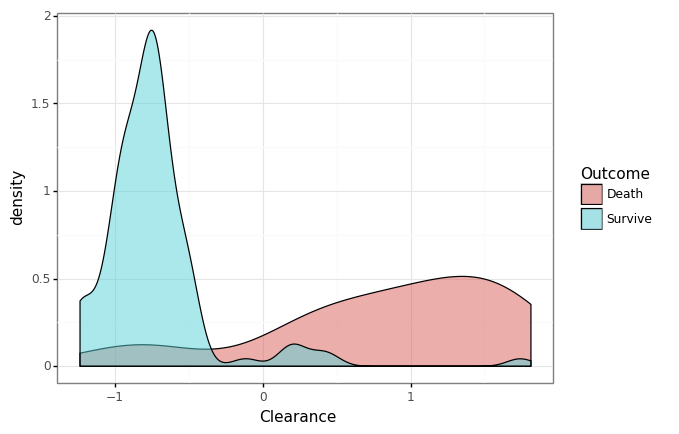

<ggplot: (135265821339)>

In [221]:
(ggplot(data)
 + geom_density(aes('Clearance',fill='Outcome'),alpha=0.5)
 + theme_bw())

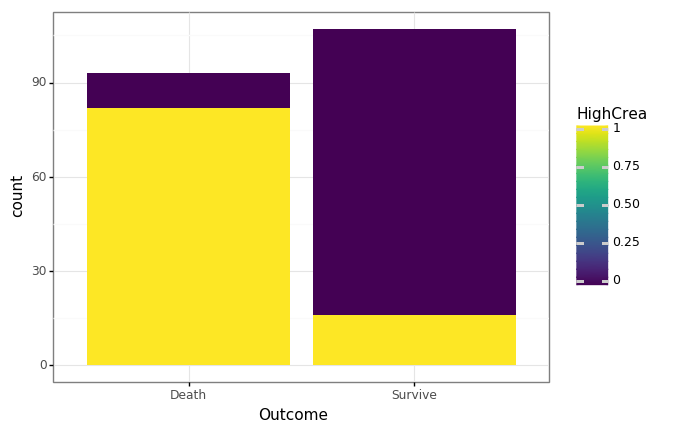

<ggplot: (-9223371901586719905)>

In [229]:
(ggplot(data)
 + geom_bar(aes(x='Outcome',group='HighCrea',fill='HighCrea'))
 + theme_bw())

Trước khi bắt tay vào dựng mô hình GLM, chúng ta cần chuẩn bị trước 3 hàm, hàm thứ nhất : trace_median có công dụng tính trung vị cho một chuỗi dữ liệu (MCMC) và xuất kết quả dưới dạng series pandas. 

Hàm thứ hai: plot_traces là một phiên bản cải tiến từ hàm traceplot của pyMC3, trong đó ta xác định Trung vị cho mỗi biểu đồ phân phối hậu nghiệm, và vẽ 1 horizontal line cho biểu đồ tuyến kí của chuỗi MCMC.

Hàm thứ ba, plot_traceOR có công dụng tương tự như trên, nhưng dành riêng cho mô hình logistic. Ta chuyển giá trị các chuỗi MCMC của tham số hồi quy: Intercept, beta... thành Odds-ratio

In [111]:
# Hàm này dùng để tính Median cho chuỗi MCMC
def trace_median(x):
    return pd.Series(np.median(x),name='Median')

# Hàm này dùng để vẽ biểu đồ phân phối hậu nghiệm và chuỗi MCMC cho mô hình GLM
def plot_traces(traces):
    ax = pm.traceplot(traces,figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['Median'] for k, v in pm.summary(traces, stat_funcs=[trace_median]).iterrows()})

    for i, mn in enumerate(pm.summary(traces, stat_funcs=[trace_median])['Median']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

# Hàm này dùng để vẽ biểu đồ phân phối hậu nghiệm và chuỗi MCMC cho mô hình Logistic, 
# các tham số hối quy trong mô hình sẽ được chuyển thành Odds-ratio bằng hàm exp() của numpy

def plot_tracesOR(traces):
    ax = pm.traceplot(traces,transform=np.exp,figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['Median'] for k, v in pm.summary(traces, transform=np.exp, stat_funcs=[trace_median]).iterrows()})

    for i, mn in enumerate(pm.summary(traces, transform=np.exp, stat_funcs=[trace_median])['Median']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='blue')

Phương pháp glm của pyMC3 là một ý tưởng rất tuyệt vời, không thua kém những giao thức rstanarm hay brms cho STAN trong ngôn ngữ R. Mục tiêu là dùng 1 hàm glm duy nhất để xây dựng mô hình Bayes, đi tắt qua các bước: khai báo priors, tham số, hàm likelihood, ... vv. Đặc biệt cú pháp của hàm glm này chịu ảnh hưởng sâu sắc từ cú pháp hàm glm của R.

Nhi dùng hàm glm để tạo 1 mô hình hồi quy logistic như sau:

In [6]:
pm.glm.GLM.from_formula('Death ~ Leucocytes + HighCrea + Clearance', 
                            data = data, 
                            family='binomial')

Dĩ nhiên, khi dùng quy trình này ta chỉ mới có phần lõi của mô hình, ta vẫn phải đóng gói mô hình glm và thiết lập chế độ lấy mẫu (suy diễn Bayes = lấy mẫu cho chuỗi MCMC). 

In [11]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('Death ~ Leucocytes + HighCrea + Clearance', 
                            data = data, 
                            family='binomial')
    trace_logistic_model = pm.sample(draws=2000,n_init=1000,chains=2,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Clearance, HighCrea, Leucocytes, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:30<00:00, 82.12it/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8811946335918851, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.


Hàm plot_traces mà chúng ta vừa tạo ra được sử dụng sau đây:

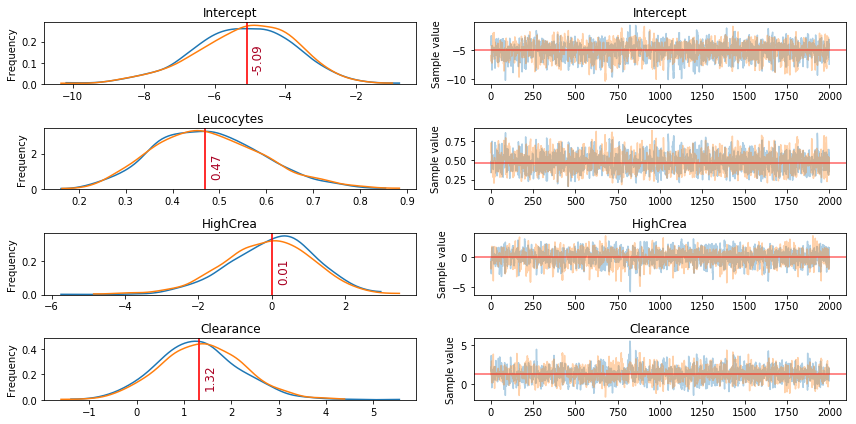

In [112]:
plot_traces(trace_logistic_model)

Vì đây là mô hình logistic, ta muốn khảo sát Odds-ratio, nên hàm plot_tracesOR được sử dụng:

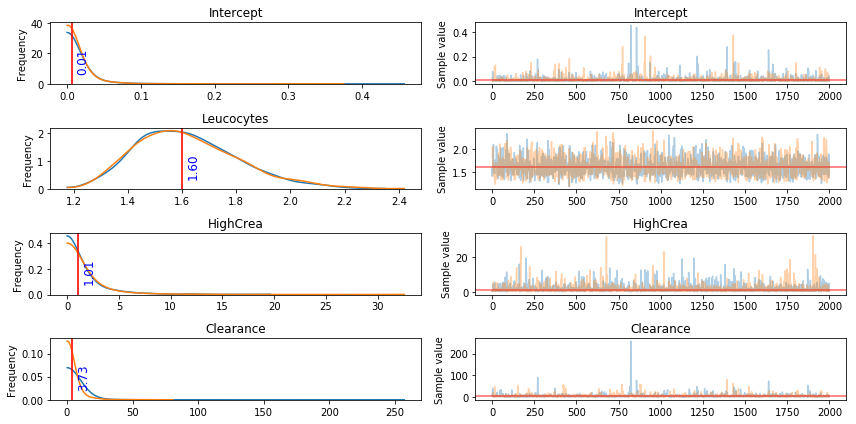

In [113]:
plot_tracesOR(trace_logistic_model)

Kết quả của mô hình dưới dạng Odds-ratio được tóm tắt bằng hàm summary, có kèm tùy chỉnh transform = np.exp (hàm exponential của numpy).

In [141]:
S=pm.summary(trace_logistic_model,
           transform=np.exp)

S.columns=['OR','sd','mc_error','HDP2.5','HDP97.5','n.eff','R.hat']

S

,OR,sd,mc_error,HDP2.5,HDP97.5,n.eff,R.hat
Intercept,0.013617,0.025047,0.000604,0.000032,0.049023,1382.606185,1.000847
Leucocytes,1.621809,0.192375,0.004491,1.274088,2.004021,1597.967644,0.999801
HighCrea,1.749917,2.362625,0.059188,0.003203,5.966350,1086.755001,1.004183
Clearance,5.805648,8.633187,0.258590,0.201776,16.525902,1098.500791,1.002614


Theo mặc định, hàm summary tính Mean, nhưng ta có thể tính bất cứ trị số thống kê nào bằng cách tạo ra các hàm riêng và áp dụng trong tùy chỉnh stat_funcs, thí dụ Median, quantile, mode...

In [142]:
pm.summary(trace_logistic_model,
           transform=np.exp,
           stat_funcs=[trace_median]).round(3)

,Median
Intercept,0.006
Leucocytes,1.598
HighCrea,1.008
Clearance,3.729


In [150]:
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))

pm.summary(trace_logistic_model,
           transform=np.exp,
           stat_funcs=[trace_quantiles,]).round(3)

,5,50,95
Intercept,0.000,0.006,0.049
Leucocytes,1.348,1.598,1.981
HighCrea,0.126,1.008,5.966
Clearance,0.918,3.729,16.526


Tiếp theo, chúng ta sẽ làm một phân tích so sánh giữa nhiều mô hình Bayes và BMA đơn giản: 
Từ 3 biến : Leucocytes, High Clearance và Creatinine, ta có thể tạo ra 6 mô hình khác nhau, cộng thêm mô hình chỉ chứa Intercept là 7 mô hình:

In [154]:
with pm.Model() as model_0:
    pm.glm.GLM.from_formula('Death ~ 1', 
                            data = data, 
                            family='binomial')
    trace_model_0 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 666.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [155]:
with pm.Model() as model_1:
    pm.glm.GLM.from_formula('Death ~ Leucocytes', 
                            data = data, 
                            family='binomial')
    trace_model_1 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Leucocytes, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 225.38it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [156]:
with pm.Model() as model_2:
    pm.glm.GLM.from_formula('Death ~ HighCrea ', 
                            data = data, 
                            family='binomial')
    trace_model_2 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [HighCrea, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 358.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [157]:
with pm.Model() as model_3:
    pm.glm.GLM.from_formula('Death ~ Clearance', 
                            data = data, 
                            family='binomial')
    trace_model_3 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Clearance, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 456.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [160]:
with pm.Model() as model_4:
    pm.glm.GLM.from_formula('Death ~ Leucocytes + HighCrea', 
                            data = data, 
                            family='binomial')
    trace_model_4 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [HighCrea, Leucocytes, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 128.00it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [161]:
with pm.Model() as model_5:
    pm.glm.GLM.from_formula('Death ~ Leucocytes + Clearance', 
                            data = data, 
                            family='binomial')
    trace_model_5 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Clearance, Leucocytes, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 124.94it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [162]:
with pm.Model() as model_6:
    pm.glm.GLM.from_formula('Death ~ HighCrea + Clearance', 
                            data = data, 
                            family='binomial')
    trace_model_6 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Clearance, HighCrea, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 215.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [163]:
with pm.Model() as model_7:
    pm.glm.GLM.from_formula('Death ~ Leucocytes + HighCrea + Clearance', 
                            data = data, 
                            family='binomial')
    trace_model_7 = pm.sample(draws=2000,n_init=1000,chains=1,tuning=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Clearance, HighCrea, Leucocytes, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:31<00:00, 79.58it/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sau khi lấy mẫu cho cả 7 mô hình, ta bắt đầu so sánh chúng với nhau. Đầu tiên, một biểu đồ forest plot cho phép khảo sát phân phối hậu nghiệm cho hệ số hồi quy mỗi biến giữa 7 phiên bản mô hình:

<IPython.core.display.Javascript object>


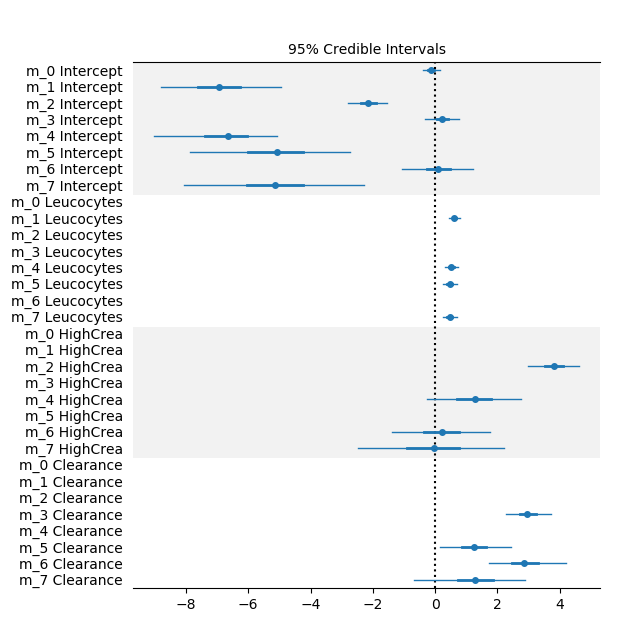

In [173]:
%matplotlib notebook

traces = [trace_model_0,
          trace_model_1,
          trace_model_2,
          trace_model_3,
          trace_model_4,
          trace_model_5,
          trace_model_6,
          trace_model_7
         ]

pm.forestplot(traces);

<IPython.core.display.Javascript object>


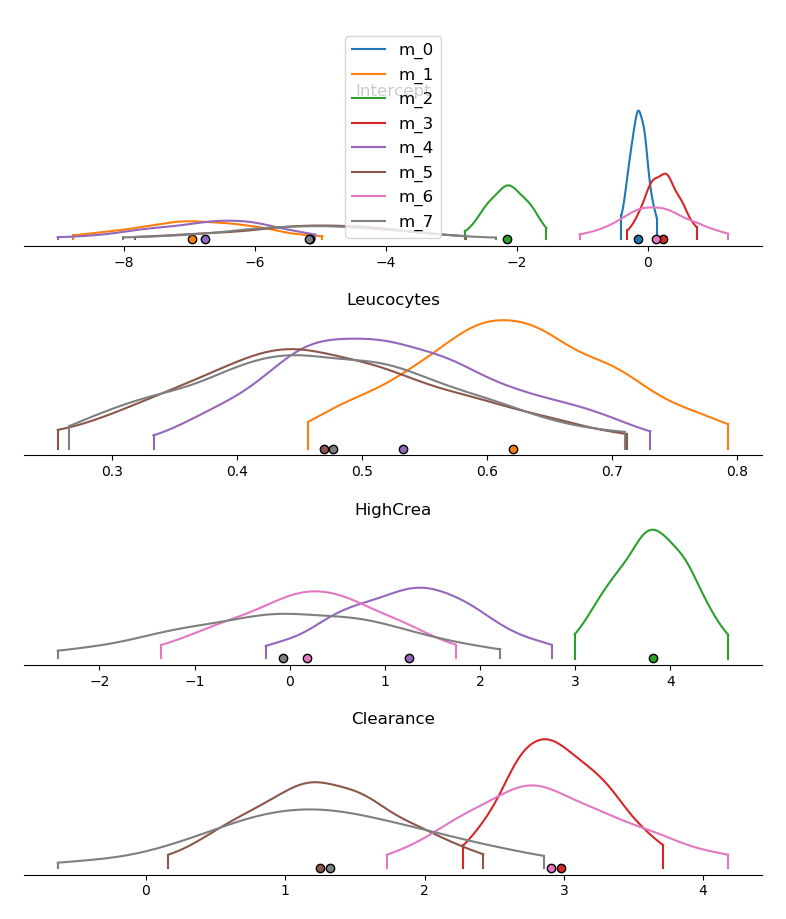

In [174]:
pm.densityplot(traces);

Việc so sánh và lựa chọn mô hình tối ưu dựa vào tiêu chí WAIC (Information criteria của Watanabe và Akaike ). Một trọng số weight sẽ được xác định cho mỗi mô hình dựa vào WAIC, mô hình tốt sẽ có WAIC thấp hơn và weight cao hơn.

Theo kết quả này, mô hình số 5 là tối ưu vì có WAIC thấp nhất.

In [192]:
mods = [model_0,
        model_1,
        model_2,
        model_3,
        model_4,
        model_5,
        model_6,
        model_7]

model_dict = dict(zip(mods,traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')
comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
5,85.23,5.35,0,0.39,26.69,0,1
1,87.03,3.91,1.8,0.27,26.45,4.09,1
4,87.1,5.21,1.88,0.18,26.01,2.75,1
7,88.35,7,3.12,0.13,28.7,2.27,1
3,123.01,2.26,37.78,0.02,20.05,19.4,1
6,125.13,3.23,39.9,0.01,20.51,19.37,1
2,161.21,2.11,75.98,0,18.61,26.82,0
0,278.24,0.98,193.01,0,2.04,27.61,0


<IPython.core.display.Javascript object>


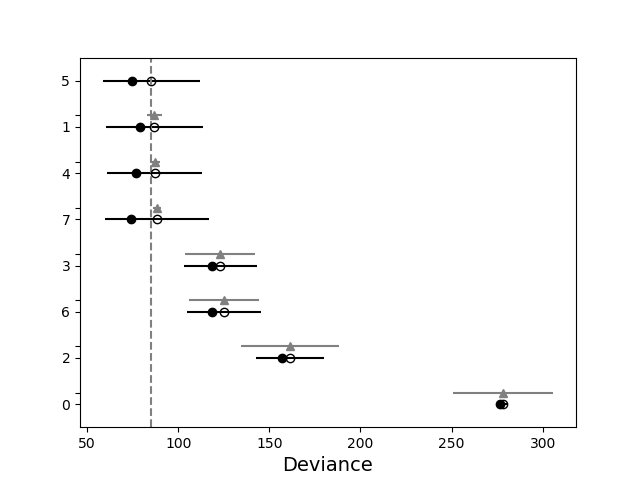

In [193]:
pm.compareplot(comp);

Đây là nội dung của mô hình 5:

In [194]:
pm.glm.GLM.from_formula('Death ~ Leucocytes + Clearance', 
                            data = data, 
                            family='binomial')

<IPython.core.display.Javascript object>


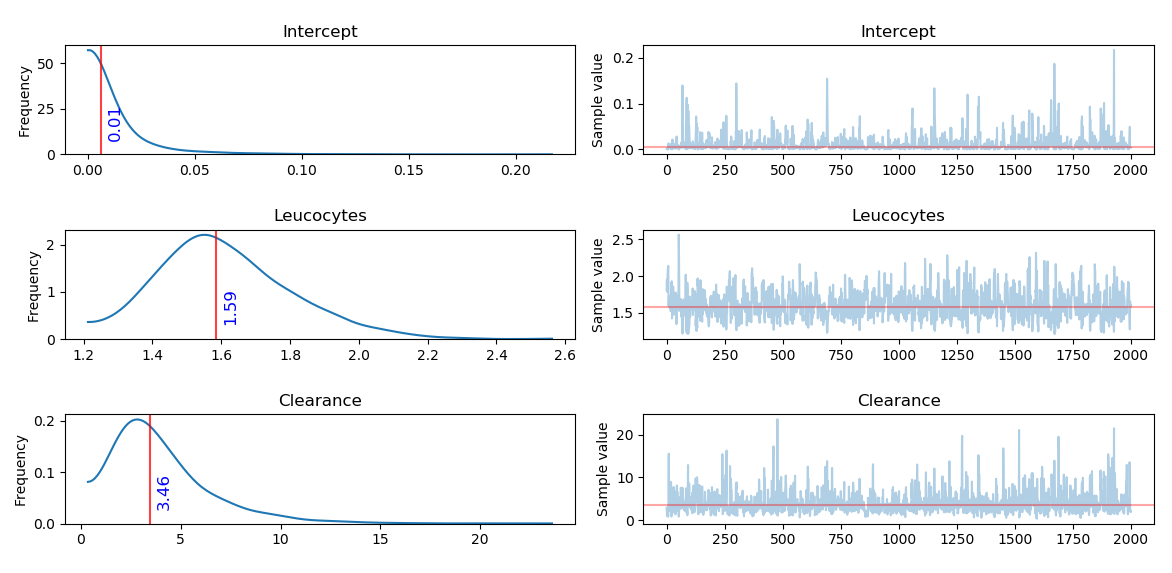

In [202]:
plot_tracesOR(trace_model_5)

In [203]:
pm.summary(trace_model_5,
           transform=np.exp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,0.012469,0.018287,0.000743,0.000078,0.047249
Leucocytes,1.610170,0.190725,0.007425,1.246748,1.978614
Clearance,4.141720,2.615093,0.083088,0.574457,9.319667


<IPython.core.display.Javascript object>


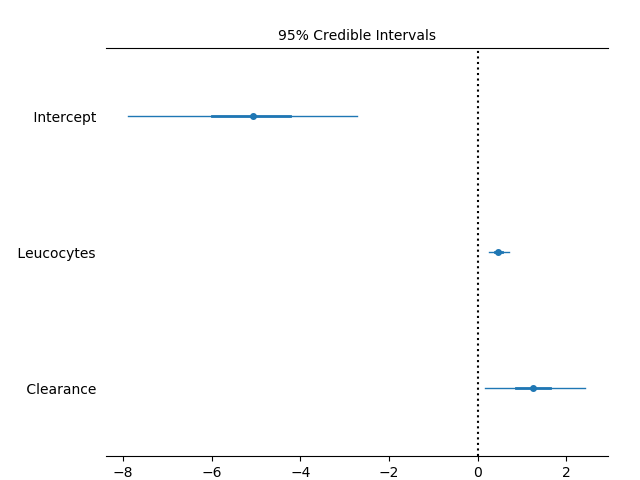

In [204]:
pm.forestplot(trace_model_5)

<IPython.core.display.Javascript object>


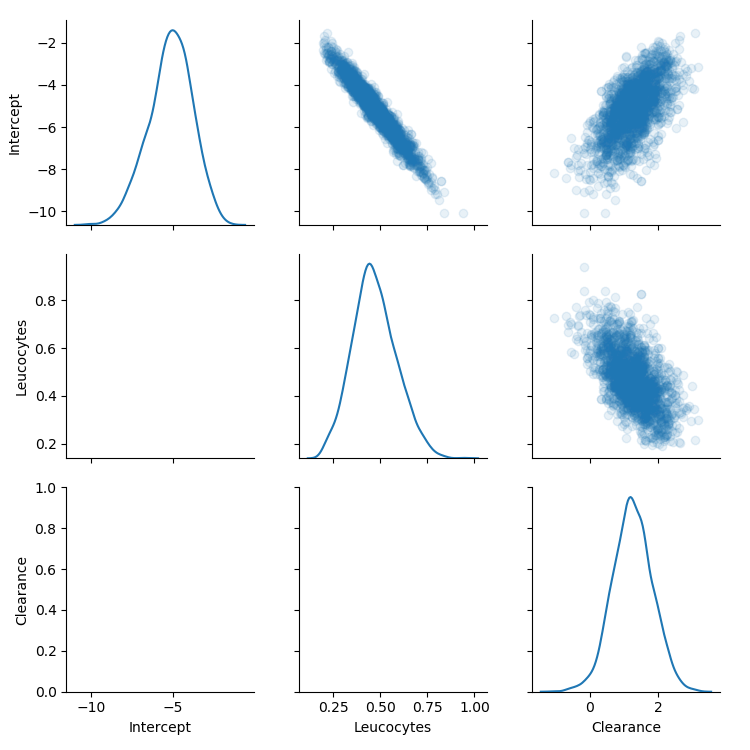

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [207]:
tracedf = pm.trace_to_dataframe(trace_model_5)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

In [213]:
import sys, IPython, scipy, matplotlib, platform
print("Bài giảng được soạn trên máy tính %s, với 1 GPU GTX 1080, hệ điều hành Windows 10 và sử dụng các thư viện:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

Bài giảng được soạn trên máy tính AMD64, với 1 GPU GTX 1080, hệ điều hành Windows 10 và sử dụng các thư viện:
Python 3.6.5
IPython 6.4.0
PyMC3 3.4.1
NumPy 1.15.0
Pandas 0.23.0
SciPy 1.1.0
Matplotlib 2.2.2

